In [2]:
import pandas as pd

In [3]:
pedidos_comida=pd.read_csv("food_orders_new_delhi.csv")

In [4]:
print(pedidos_comida.head())


   Order ID Customer ID Restaurant ID  Order Date and Time  \
0         1       C8270         R2924  2024-02-01 01:11:52   
1         2       C1860         R2054  2024-02-02 22:11:04   
2         3       C6390         R2870  2024-01-31 05:54:35   
3         4       C6191         R2642  2024-01-16 22:52:49   
4         5       C6734         R2799  2024-01-29 01:19:30   

  Delivery Date and Time  Order Value  Delivery Fee    Payment Method  \
0    2024-02-01 02:39:52         1914             0       Credit Card   
1    2024-02-02 22:46:04          986            40    Digital Wallet   
2    2024-01-31 06:52:35          937            30  Cash on Delivery   
3    2024-01-16 23:38:49         1463            50  Cash on Delivery   
4    2024-01-29 02:48:30         1992            30  Cash on Delivery   

  Discounts and Offers  Commission Fee  Payment Processing Fee  \
0            5% on App             150                      47   
1                  10%             198                  

In [5]:
print(pedidos_comida.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB
None


#Data cleaning 
conversion columnas hora y fecha a datetime

In [6]:
pedidos_comida['order date and time']=pd.to_datetime(pedidos_comida['Order Date and Time'])
pedidos_comida['Delivery Date and Time']=pd.to_datetime(pedidos_comida['Delivery Date and Time'])

#verificar valores monetarios en formato correcto para realizar calculos
se  crea una funcion para extraer valores numericos desde 'discount and offers'

In [7]:
def extraer_descuento(discount_str):
    if 'off' in discount_str:
        #monto fijo
        return float(discount_str.split(' ')[0])
    elif '%'in discount_str:
        #porcentaje descuento
        return float(discount_str.split('%')[0])
    else:
        #sin descuento
        return 0.0

#aplicar la funcion para crear  columna 'nuevo descuento'

In [8]:
pedidos_comida['discount percentage'] = pedidos_comida['Discounts and Offers'].astype(str).apply(lambda x: extraer_descuento(x))


#para porcentajes de descuento, calcular el descuento basado en el precio del pedido

In [9]:
pedidos_comida['discount amount']=pedidos_comida.apply(lambda x: (x['Order Value'] * x['discount percentage'] /100)
                                                                  if x['discount percentage'] >1
                                                                  else x['discount percentage'], axis=1)

#ajustar 'discount amount' para descuentos fijos drectamente especificados en la columna 'discount offers'

In [10]:
pedidos_comida['discount amount']=pedidos_comida.apply(lambda x: x['discount amount'] if x['discount percentage'] <=1
                                                       else x['Order Value'] *x['discount percentage'] /100, axis=1)

In [11]:
print(pedidos_comida[['Order Value','Discounts and Offers', 'discount percentage','discount amount']].head(), pedidos_comida.dtypes)

   Order Value Discounts and Offers  discount percentage  discount amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                  NaN                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time               object
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
order date and time       datetime64[ns]
discount percentage    

#data cleaning listo
order date and time y delivery date and time se trasnformaron  a formato datetime
una nueva columna , discount amount , fue creada en base a discount and offers , esto se hizo extrayendo porcentahe de descuentos o montos de descuento fijos, y aplicandolod al valor del pedido.
se agrego decuento de porcentaje para representar el descuento a aplicar o el monto fijo durectamente. 

#"Análisis de Costos y Rentabilidad".

#Para el análisis de costos, consideraremos los siguientes costos asociados con cada pedido:

Tarifa de Entrega: La tarifa cobrada por entregar el pedido.
Tarifa de Procesamiento de Pagos: La tarifa por procesar el pago.
Monto del Descuento: El descuento proporcionado en el pedido.
Calcularemos el costo total para la plataforma por pedido y luego agregaremos estos datos para comprender la estructura de costos en general.

Los ingresos para la plataforma se derivan principalmente de la Tarifa de Comisión. Calcularemos la ganancia neta restando los costos totales (incluidos los descuentos) de los ingresos generados a través de las tarifas de comisión.

In [12]:
#calculo de rentabilidad por pedido

pedidos_comida['Total Costs']=pedidos_comida['Delivery Fee']+ pedidos_comida['Payment Processing Fee']+pedidos_comida['discount amount']
pedidos_comida['Revenue']=pedidos_comida['Commission Fee']
pedidos_comida['Profit']=pedidos_comida['Revenue']-pedidos_comida['Total Costs']

# agrgar datos para obtener metricas generales

total_orders = pedidos_comida.shape[0]
total_revenue = pedidos_comida['Revenue'].sum()
total_costs = pedidos_comida['Total Costs'].sum()
total_profit = pedidos_comida['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)


{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 232709.85, 'Total Profit': -105719.85}


#Para comprender mejor la distribución de los costos, ingresos y ganancias, vamos a graficar:

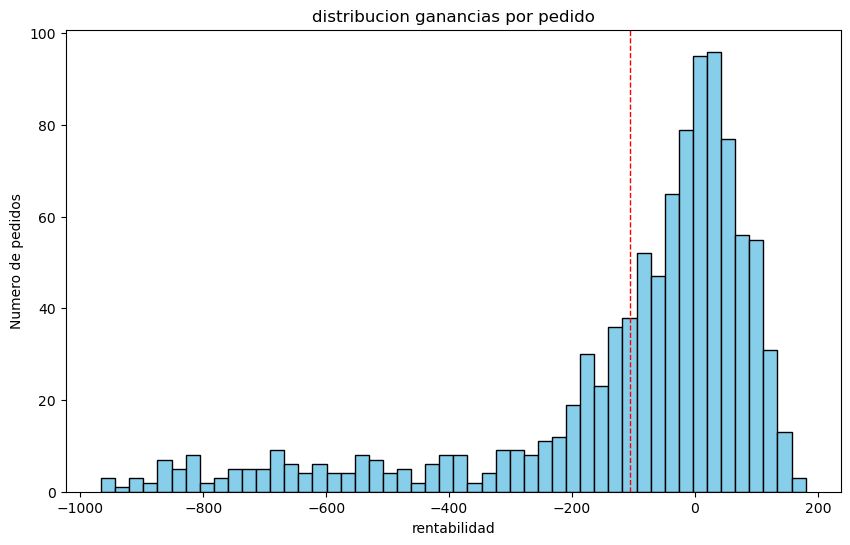

In [13]:
#Un histograma de ganancias por pedido para visualizar la distribución de pedidos rentables y no rentables.
#Un gráfico circular para visualizar la proporción de costos totales (tarifas de entrega, tarifas de procesamiento de pagos y descuentos).
#Un gráfico de barras para comparar los ingresos totales, los costos totales y las ganancias totales.

import matplotlib.pyplot as plt

#histograma 

plt.figure(figsize=(10, 6))
plt.hist(pedidos_comida['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('distribucion ganancias por pedido')
plt.xlabel('rentabilidad')
plt.ylabel('Numero de pedidos')
plt.axvline(pedidos_comida['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

El histograma muestra una amplia distribución de ganancias por pedido, con un número considerable de pedidos que resultan en pérdidas (ganancias por debajo de 0). La línea punteada roja indica la ganancia promedio, la cual se encuentra en territorio negativo, resaltando la situación general de pérdidas

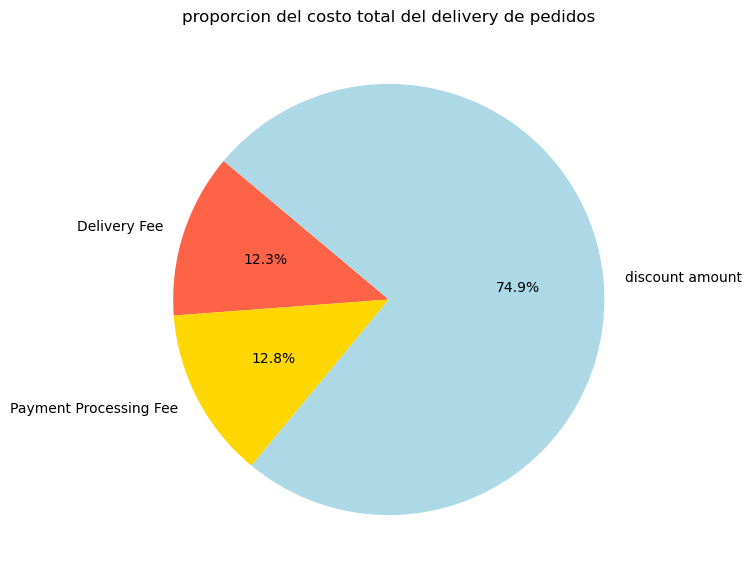

In [14]:
# pie chart para proporcion de costos totales

costs_breakdown = pedidos_comida[['Delivery Fee', 'Payment Processing Fee', 'discount amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('proporcion del costo total del delivery de pedidos')
plt.show()

El gráfico circular ilustra la desglose de los costos totales en tarifas de entrega, tarifas de procesamiento de pagos y montos de descuento. Los descuentos constituyen una parte significativa de los costos, lo que sugiere que las estrategias promocionales podrían estar impactando fuertemente la rentabilidad general.

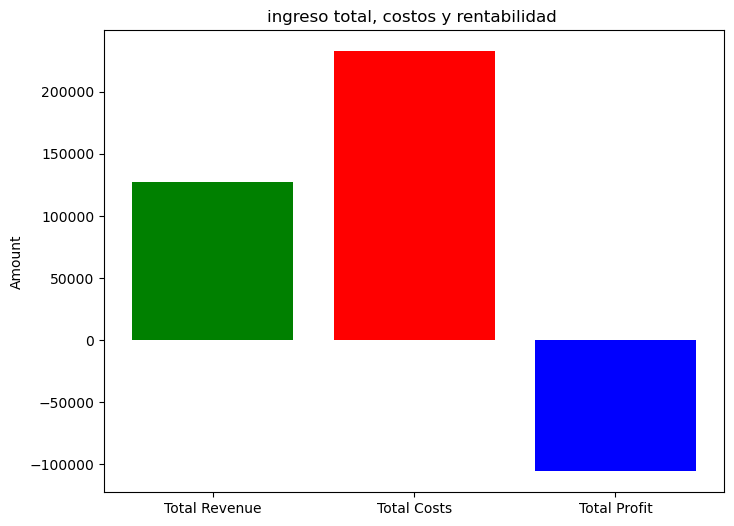

In [17]:
#Ahora, comparemos los ingresos totales, los costos totales y las ganancias totales (pérdida neta en nuestro caso):

# grafico de barras para ingreso total, costos y rentabilidad 

totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('ingreso total, costos y rentabilidad ')
plt.ylabel('Amount')
plt.show()

El gráfico de barras compara los ingresos totales, los costos totales y las ganancias totales. Representa visualmente la brecha entre los ingresos y los costos, mostrando claramente que los costos superan a los ingresos, lo que conduce a una pérdida total.

#nueva estrategia para rentabilidad